<a href="https://colab.research.google.com/github/benmsanderson/tcre-star/blob/main/ESGF_read_land_fluxes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.simplefilter("ignore")

from itertools import groupby

In [2]:
pip install nc-time-axis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.5 MB/s eta 0:00:00


In [3]:
pip install h5pyd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h5pyd: filename=h5pyd-0.16.0-py3-none-any.whl size=155597 sha256=77ee5a45bcb51e8269d4ede3f65696dfaf981115d453e9c345fb64175198ceb0
  Stored in directory: /root/.cache/pip/wheels/c7/f7/62/68d81790a12e92b5b74c09f803b413276c291853ae585d798b
Successfully built h5pyd


In [4]:
 pip install netcdf4==1.6.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 34.0 MB/s eta 0:00:00


In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import h5pyd
import xarray as xr
import nc_time_axis

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Search using ESGF API

In [6]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    payload["latest"]="true"

    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = []
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        #print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    result=sorted(all_files)
    tmp = [[c for _, c in g] for _, g in groupby(zip( [x.split('_')[-3] for x in result],result), key=lambda x: x[0])]
    return tmp

In [7]:
#mdls=["CanESM5","GFDL-ESM4","GISS-E2-1-G","GISS-E2-1-H","CESM2-WACCM","MIROC-ES2L","CESM2-WACCM","UKESM1-0-LL","IPSL-CM6A-LR"]
mdls=["CanESM5"]

In [8]:
scens={'ssp119'}#,'ssp126','ssp245','ssp585','ssp534-over'}
vars={'nbp'}

In [9]:

result_hist={}
result_scn={}

for i,mdl in enumerate(mdls):
  result_scn[mdl]={}
  result_hist[mdl]={}
  for j,var in enumerate(vars):
        result_scn[mdl][var]={}
        result_hist[mdl][var]= esgf_search(activity_id='CMIP', table_id='Lmon',
                      experiment_id='historical', variable_id=var,
                      source_id=mdl)
        for k,scn in enumerate(scens):
              result_scn[mdl][var][scn] = esgf_search(activity_id='ScenarioMIP', table_id='Lmon',
                            experiment_id=scn, variable_id=var,
                            source_id=mdl)



In [10]:
result_area={}
for i,mdl in enumerate(mdls):

  result_area[mdl] = esgf_search(variable_id='areacella', activity_id='CMIP',
                          source_id=mdl)

In [14]:
ds_hist={}
for i,mdl in enumerate(mdls):
  tmp=[]
  tmp.append( xr.open_dataset(result_area[mdl][0][0]))
  for j,var in enumerate(vars):
       if len(result_hist[mdl][var])>0:
         tmp.append(xr.open_mfdataset(result_hist[mdl][var][0], combine='by_coords',use_cftime=True))
  ds_hist[mdl]=xr.merge(tmp)


In [18]:
ds_scn={}
for i,mdl in enumerate(mdls[:1]):
    ds_scn[mdl]={}
    for j,scn in enumerate(scens):
      tmp=[]
      tmp.append(xr.open_dataset(result_area[mdl][0][0]))
      for k,var in enumerate(vars):

       if len(result_scn[mdl][var][scn])>0:
          if scn=='ssp534-over':
              tmp0 = xr.open_mfdataset(result_scn[mdl][var]['ssp585'][0], combine='by_coords',use_cftime=True)
              tmp1 = xr.open_mfdataset(result_scn[mdl][var]['ssp534-over'][0], combine='by_coords',use_cftime=True)
              tmps=xr.concat((tmp0.sel(time=slice("1850-01-01", "2039-12-30")),tmp1.sel(time=slice("2040-01-01", "2300-12-30"))),'time')
          else:
              tmps = xr.open_mfdataset(result_scn[mdl][var][scn][0], combine='by_coords',use_cftime=True)
          tmp.append(xr.concat([ds_hist[mdl][var],tmps[var]],'time'))
      ds_scn[mdl][scn]=xr.merge(tmp)


In [20]:
ds_scn['CanESM5']['ssp119']

<xarray.Dataset>
Dimensions:    (lat: 64, bnds: 2, lon: 128, time: 3012)
Coordinates:
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    areacella  (lat, lon) float32 ...
    nbp        (time, lat, lon) float32 dask.array<chunksize=(1980, 64, 128), meta=np.ndarray>
Attributes: (12/52)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-1ppy
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/75ee2e71-245d-44fb-bc70-b12c0ec...
    variable_id:                 areacella
    variant_label:               r1i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

In [24]:
ds_area={}
ts_gm={}
for i,mdl in enumerate(mdls):
  ts_gm[mdl]={}
  for j,scn in enumerate(scens):
    ts_gm[mdl][scn]={}
    #total_area = ds_scn[mdl][scn].areacella.sum(dim=['lon', 'lat'])
    for k,var in enumerate(vars):
      if len(result_scn[mdl][var][scn])>0:
        ts_gm[mdl][scn][var]=(ds_scn[mdl][scn][var]*ds_scn[mdl][scn].areacella).sum(dim=['lon', 'lat'])

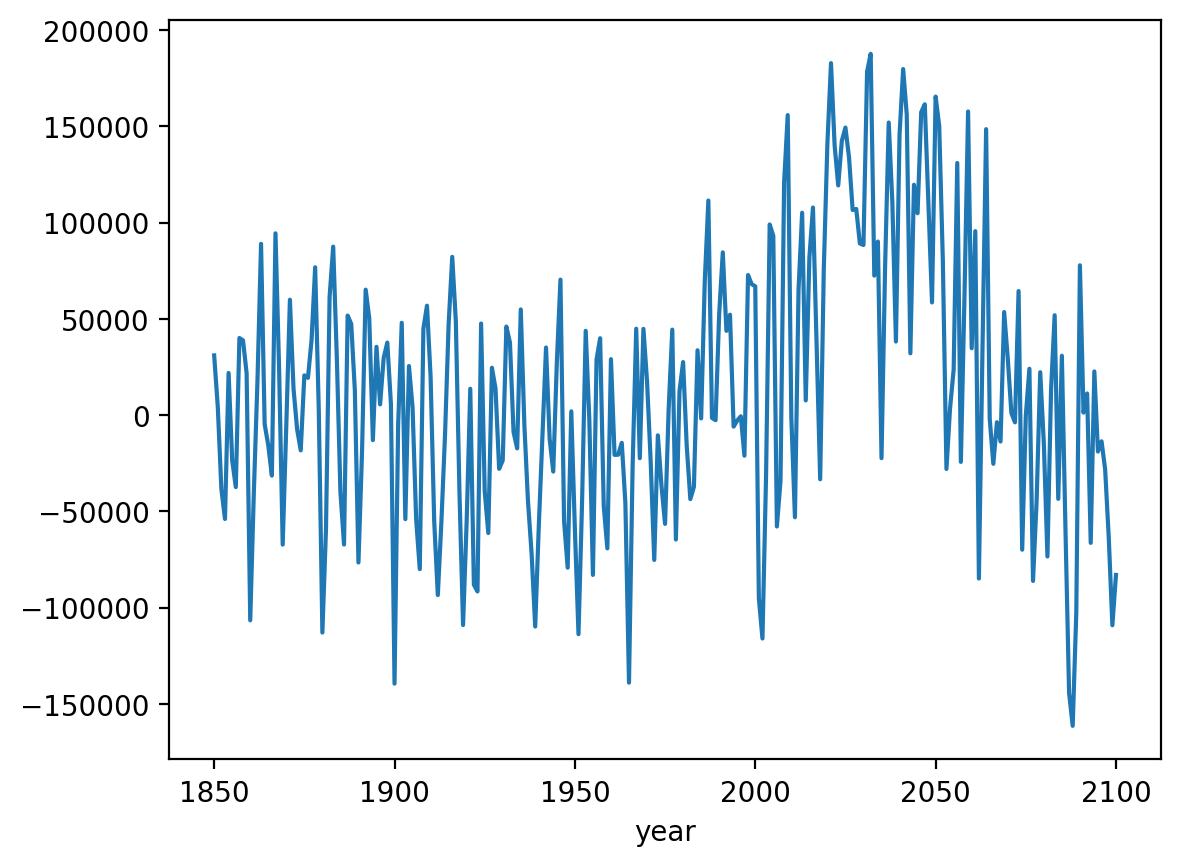

In [25]:
ts_gm['CanESM5']['ssp119']['nbp'].groupby('time.year').mean().plot()

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
datadir='/content/drive/MyDrive/tcre_star'

In [29]:

for i,mdl in enumerate(mdls):
  for j,scn in enumerate(scens):
    for k,var in enumerate(vars):
      if len(result_scn[mdl][var][scn])>0:
        ds_scn[mdl][scn].groupby('time.year').mean().to_netcdf(datadir+'/'+mdl+'_'+scn+'.nc')

In [33]:
import csv

with open(datadir+'/mdls.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(mdls)

In [32]:
with open(datadir+'/scens.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(scens)